/home/daniel/Documents/Utec/BigData/kafka/.ven/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/daniel/Documents/Utec/BigData/kafka/.ven/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/daniel/Documents/Utec/BigData/kafka/.ven/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/daniel/Documents/Utec/BigData/kafka/.ven/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retval

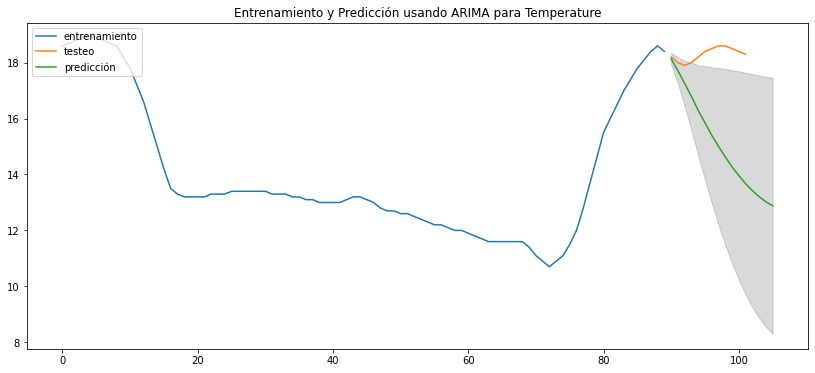

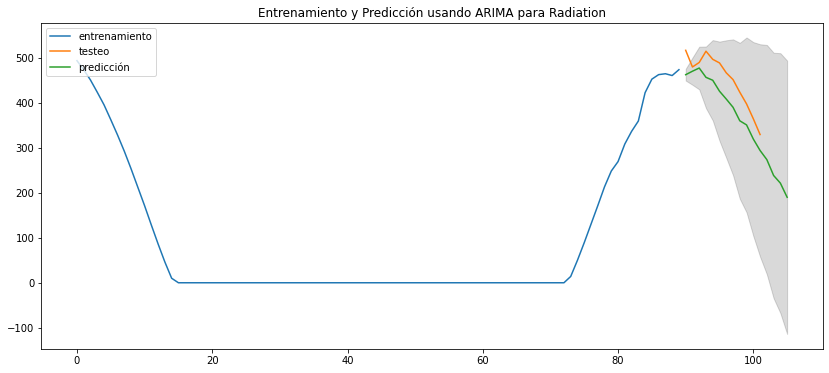

KeyboardInterrupt: 

In [10]:
from redis_manager import StoreRedis
from config import REDIS_STORE_KEY
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.stattools import adfuller 
from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot
import IPython
import IPython.display
import statsmodels.api as sm


store_redis = StoreRedis()





def ModelArima(Signal,size_train,p ,q = 1, d = 0): #p son los lags de la autocorrelación
    train=Signal[:size_train]
    test=Signal[size_train:]
    resultado_adfuller=adfuller(train)
    Primera_Dif=adfuller(train.diff().dropna())
    Segunda_Dif=adfuller(train.diff().diff().dropna())
        
    modelo = ARIMA(train, order=(p,d,q),)

    modelo_fit = modelo.fit()
    
    tamaño_predicción=len(test)+4
    #output = model_fit.forecast(4)
    predicciones=modelo_fit.get_forecast(tamaño_predicción)
    return train, test, predicciones
    
def plot_series(train, test, predicciones, label_y):
    
    conf = predicciones.conf_int(alpha=0.05)
    lower=pd.Series(conf.values[:,0],predicciones.predicted_mean.index)
    high=pd.Series(conf.values[:,1],predicciones.predicted_mean.index)
    
    ax=plt.figure(figsize=(14,6))
    plt.plot(train[label_y],label="entrenamiento")
    plt.plot(test[label_y],label="testeo")
    # test.plot(legend=True,label="testeo")
    predicciones.predicted_mean.plot(legend=True,label='predicción')
    plt.fill_between(lower.index, lower,high, color='k',alpha=0.15)
    plt.legend(loc="upper left", fontsize=10)
    plt.title(f'Entrenamiento y Predicción usando ARIMA para {label_y}')


#autocorrelation_plot(temperature_df)
"""
plt.ion()
for i in range(100):
    x = range(i)
    y = range(i)
    # plt.gca().cla() # optionally clear axes
    plt.plot(x, y)
    plt.title(str(i))
    plt.draw()
    plt.pause(1)
    IPython.display.clear_output()
"""

def get_p(data):
    ax=sm.tsa.acf(data)
    k=0
    for i in range(0,len(ax)):
        if ax[i] >= 0.5:
            k=k+1
        else:
            None
    return k

plt.ion()
while True:
    data_train = store_redis.response(REDIS_STORE_KEY, 100)

    temperature_list = [i["temperature"] for i in data_train]
    timestamp_list = [i["timestamp"] for i in data_train]
    datetime_list = [i["date_time"] for i in data_train]
    temperature_df = pd.DataFrame({
        "Temperature": temperature_list,
        #"Datetime": datetime_list,
        })   
    
    radiation_list = [i["radiation"] for i in data_train]
    radiation_df = pd.DataFrame({
        "Radiation": radiation_list,
        #"Datetime": datetime_list,
        })   
    

    train, test, predicciones = ModelArima(temperature_df, 90, p=get_p(temperature_df))
    train_r, test_r, predicciones_r =  ModelArima(radiation_df, 90, p=get_p(radiation_df))
    # IPython.display.clear_output()
    plot_series(train, test, predicciones , "Temperature")
    plot_series(train_r, test_r, predicciones_r, "Radiation")
    plt.pause(5)
    IPython.display.clear_output()
  

  
    
